In [1]:
# Import all the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("✅ Libraries imported successfully.")

✅ Libraries imported successfully.


In [2]:
# --- 1. Data Loading, Cleaning, and Preprocessing ---

# Load the dataset (make sure it's in the same folder as your notebook)
file_path = 'training_data.csv'
df = pd.read_csv(file_path)

print("--- Initial Data Overview ---")
display(df.head())

# Drop the 'ID' column as it's not a predictive feature
df = df.drop('ID', axis=1)

# Define features (X) and the target variable (y)
X = df.drop('Risk', axis=1)
y = df['Risk']

# Identify categorical and numerical columns for preprocessing
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

# Simple data cleaning: fill missing values
for col in categorical_features:
    if X[col].isnull().sum() > 0:
        X[col].fillna('missing', inplace=True) # Fill with a placeholder

for col in numerical_features:
    if X[col].isnull().sum() > 0:
        X[col].fillna(X[col].median(), inplace=True) # Fill with the column's median

print("\n✅ Data cleaning and preprocessing complete.")

--- Initial Data Overview ---


,ID,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,1122,33,male,1,rent,little,moderate,2384,36,repairs,bad
1,49,48,male,2,own,NaN,NaN,5190,27,repairs,good
2,156,39,female,1,own,NaN,moderate,932,6,education,good
3,307,30,male,2,own,NaN,moderate,2028,12,car,good
4,1288,48,male,2,own,little,little,1082,12,car,bad



✅ Data cleaning and preprocessing complete.


/var/folders/s7/jxy5nj_92ms19pmy88kw45zm0000gn/T/ipykernel_8431/624227342.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna('missing', inplace=True) # Fill with a placeholder


In [3]:
# --- 2. Data Splitting (80% Train, 20% Test) ---

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set contains {X_train.shape[0]} samples.")
print(f"Testing set contains {X_test.shape[0]} samples.")

Training set contains 896 samples.
Testing set contains 224 samples.


In [4]:
# --- 3. Decision Tree Model Training ---

# Create a preprocessor to one-hot encode categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep numerical columns as they are
)

# Create the full model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        max_depth=5,             # Limits the complexity for readability
        min_samples_leaf=10,       # Ensures rules aren't too specific
        random_state=42
    ))
])

# Train the model
model_pipeline.fit(X_train, y_train)

print("✅ Model training complete.")

✅ Model training complete.


In [5]:
# --- 4. Rule Extraction and Interpretation ---

# Get the correct feature names after one-hot encoding
feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Generate and print the text-based rules
tree_rules = export_text(model_pipeline.named_steps['classifier'], feature_names=list(feature_names))

print("--- 🤖 Extracted Decision Rules ---")
print(tree_rules)

--- 🤖 Extracted Decision Rules ---
|--- cat__Checking account_missing <= 0.50
|   |--- remainder__Duration <= 8.50
|   |   |--- remainder__Age <= 26.50
|   |   |   |--- class: bad
|   |   |--- remainder__Age >  26.50
|   |   |   |--- remainder__Job <= 2.50
|   |   |   |   |--- remainder__Age <= 35.50
|   |   |   |   |   |--- class: good
|   |   |   |   |--- remainder__Age >  35.50
|   |   |   |   |   |--- class: good
|   |   |   |--- remainder__Job >  2.50
|   |   |   |   |--- class: bad
|   |--- remainder__Duration >  8.50
|   |   |--- remainder__Duration <= 43.50
|   |   |   |--- cat__Checking account_little <= 0.50
|   |   |   |   |--- cat__Saving accounts_missing <= 0.50
|   |   |   |   |   |--- class: bad
|   |   |   |   |--- cat__Saving accounts_missing >  0.50
|   |   |   |   |   |--- class: good
|   |   |   |--- cat__Checking account_little >  0.50
|   |   |   |   |--- remainder__Job <= 2.50
|   |   |   |   |   |--- class: bad
|   |   |   |   |--- remainder__Job >  2.50
|   |  

--- 📊 Visualizing Model Performance on the Test Set ---
Overall Model Accuracy: 67.41%



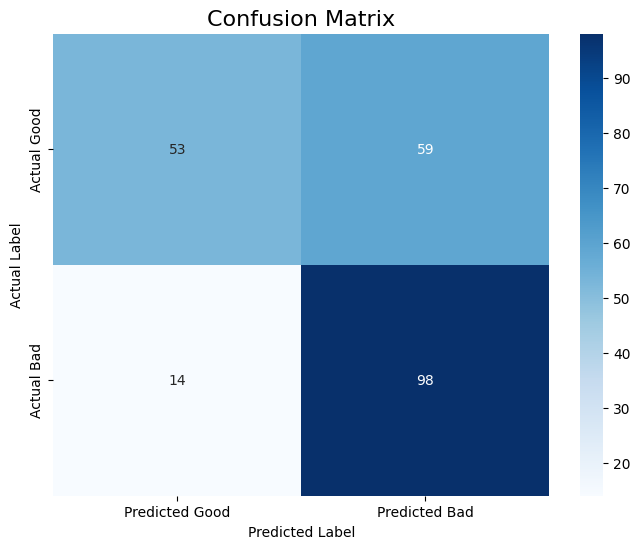

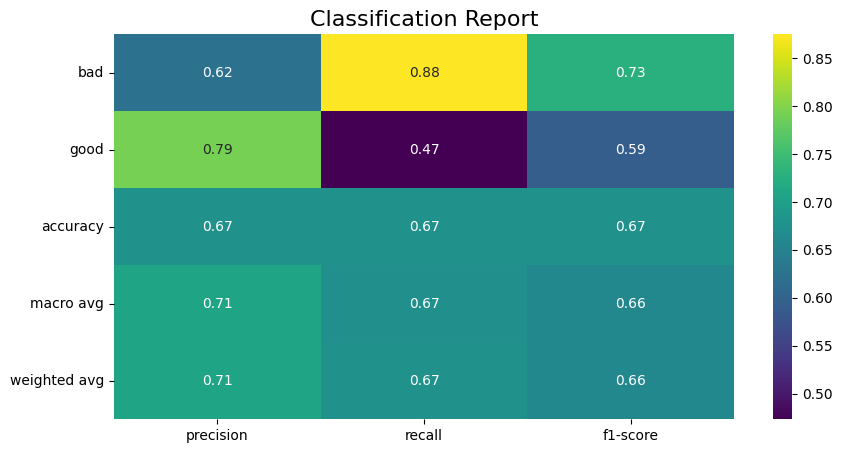

In [6]:
# --- 5. Results Presentation with Seaborn ---

print("--- 📊 Visualizing Model Performance on the Test Set ---")

# Make predictions on the unseen test data
y_pred = model_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Model Accuracy: {accuracy:.2%}\n")

# a) Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred, labels=['good', 'bad'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Good', 'Predicted Bad'],
            yticklabels=['Actual Good', 'Actual Bad'])
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# b) Classification Report as a Heatmap
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).iloc[:-1, :].T # Convert to DataFrame for plotting

plt.figure(figsize=(10, 5))
sns.heatmap(report_df, annot=True, cmap='viridis', fmt='.2f')
plt.title('Classification Report', fontsize=16)
plt.show()